In [8]:
from qubitdriver2 import qubit

from matplotlib import pyplot as plt
import numpy as np
import time

In [9]:
def gauss(mu=0,si=0,length=100,maxv=30000):
    x = np.arange(0,length)
    y = 1/(2*np.pi*si**2)*np.exp(-(x-mu)**2/si**2)
    y = y/np.max(y)*maxv
    return y

In [10]:
cavityChannel = 4
readoutChannel = 0

q = qubit(cavityOutputChannel = cavityChannel, cavityLOChannel = 1, readoutChannel =  readoutChannel)

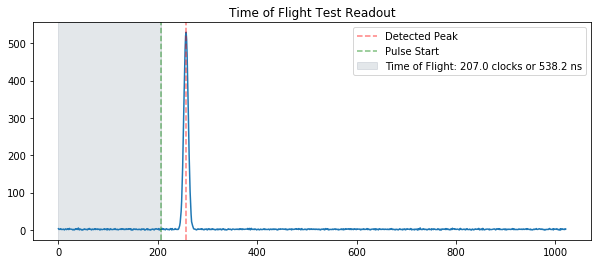

In [15]:
#TOF

freq = 2000
gain = 32767
pulseWidth = 100
offset = 0

iterations = 1


xg_i = gauss(mu=16*pulseWidth/2, si=pulseWidth, length=16*pulseWidth, maxv=gain)
xg_q = np.zeros(len(xg_i))
q.soc.gens[cavityChannel-1].load(addr=0, xin_i=xg_i, xin_q=xg_q)

q._writeASM(scopeMode = True,
            cavityStartFrequency = freq,
            cavityStartGain = gain,
            cavityPulseWidthStart = pulseWidth, 
            tOffset = offset,
            readoutChannelEnable = [True,True], #For simplicity, we just turn both on. 
            cEnvelope = True,
           )

rawAmps = []
for i in range(iterations):
#     q.readoutChannelSetup(readoutFrequency = freq,
#                      readoutWidth = pulseWidth,
#                      scopeMode = True)
    q.runProcessor()
    isamp,qsamp = q.getSamples(scopeMode = True)
    rawAmps.append(np.abs(isamp + 1j * qsamp))
    
amps = [0] * len(rawAmps[0])
for set in rawAmps:
    for i in range(len(set)):
        amps[i] += set[i]

for i in range(len(amps)):
    amps[i] = amps[i] / iterations
    
times = np.linspace(offset, 1022 - 1, 1022)

bestLine = np.where(amps == np.amax(amps))[0][0]
bestLine = bestLine + offset

tof = bestLine - (pulseWidth / 2) #Calculate where the pulse actually began

fig = plt.figure()
fig.set_figwidth(10)
plt.plot(times, amps)
plt.axvline(bestLine, ls="--", color="red", alpha=0.5, label="Detected Peak")
plt.axvline(tof, ls="--", color="green", alpha = 0.5, label="Pulse Start")
tofLabel = "Time of Flight: " + str(tof) + " clocks or " + str(tof * 2.6) + " ns"
plt.axvspan(offset, tof, color="lightslategrey", alpha=0.2, label=tofLabel)
plt.legend()
plt.title("Time of Flight Test Readout")
plt.show()
